Name -- Tharundi P.D.
Index -- 190626H

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
f = open(r'./templeSparseRing/templeSR_par.txt', 'r')
assert f is not None
n = int(f.readline())
l = f.readline().split()
im1_fn = l[0]

K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

l = f.readline().split()
im2_fn = l[0]

K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

im1 = cv.imread(r'./templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'./templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

In [3]:
sift =  cv.SIFT_create()
kp1, desc1 = sift.detectAndCompute(im1, None)
kp2, desc2 = sift.detectAndCompute(im2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k = 2)

good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)


F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
E = K2.T @ F @ K1 
print("Fundamental Matrix\n", F)
print("Essential Matrix\n", E)

retval ,R, t, mask = cv.recoverPose(E, pts1, pts2, K1)
print("R\n", R)
print("t\n", t)

R_t_1 = np.concatenate((R1, t1), axis=1)
R2_ = R1 @ R
t2_ =  R1 @ t
R_t_2 = np.concatenate((R2_, t2_), axis=1)

P1 = K1 @ np.hstack((R1, t1))
P2_ = K2 @ R_t_2

print("Camera Matrix P2\n", P2_)

Fundamental Matrix
 [[ 5.89837378e-07  2.55924451e-06 -3.07834748e-02]
 [ 5.16496278e-06 -3.34485875e-07 -1.30711239e-03]
 [ 2.85145830e-02 -2.54326943e-03  1.00000000e+00]]
Essential Matrix
 [[ 1.36347762e+00  5.93739189e+00 -4.55714881e+01]
 [ 1.19826019e+01 -7.78807148e-01  2.62126165e-01]
 [ 4.55633123e+01 -2.82616999e+00 -2.64642337e-02]]
R
 [[ 0.99826028 -0.05777815  0.01175184]
 [ 0.04903496  0.92422392  0.37868948]
 [-0.03274131 -0.37745441  0.92544917]]
t
 [[-0.00571028]
 [-0.96705716]
 [ 0.25449526]]
Camera Matrix P2
 [[ 1.37274033e+02  1.54398322e+03  1.68878798e+01 -1.53842749e+03]
 [ 1.53529427e+03 -8.64435396e+01 -1.57208837e+02  1.17454234e+01]
 [ 7.20079838e-02  2.00090768e-01 -9.77127696e-01 -7.46481506e-02]]


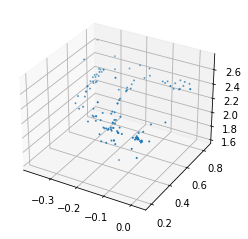

In [5]:
points4d = cv.triangulatePoints(P1, P2_, pts1.T, pts2.T)
points4d/= points4d[3, :]
X = points4d[0,:]
Y = points4d[1,:]
Z = points4d[2,:]

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1, cmap='gray')

plt.show()